In [1]:
import os
import sgml, dproc, sgml, sgpp, sgutil
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline

In [2]:
path = ['data', 'model', 'img', 'result']
for i in path:
    if not os.path.exists(i):
        os.mkdir(i)

In [3]:
if not os.path.exists('data/train.csv'):
    !kaggle competitions download -c playground-series-s4e9
    !unzip playground-series-s4e9.zip -d data
    !rm playground-series-s4e9.zip
    !kaggle datasets download taeefnajib/used-car-price-prediction-dataset
    !unzip used-car-price-prediction-dataset.zip -d data
    !rm used-car-price-prediction-dataset.zip

In [5]:
sc = sgutil.SGCache('img', 'result', 'model')
p = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.PandasConverter(index_col = 'id')
)
p2 = make_pipeline(
    sgpp.PolarsProcessor({'milage': pl.String, 'price': pl.String}),
    sgpp.ExprProcessor({
        'milage': pl.col('milage').str.replace_all(' mi\\.|,', '').cast(pl.Int32),
        'price': pl.col('price').str.replace_all('\\$|,', '').cast(pl.Int32),
    }),
    sgpp.PandasConverter(index_col = 'id')
)
df_train = p.fit_transform(['data/train.csv'])
df_test = p.transform(['data/test.csv'])
df_org = p2.fit_transform(['data/used_cars.csv'])
df_org.set_index(-(df_org.index + 1), inplace = True)
df_org.index.name = 'id'

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   brand         188533 non-null  category
 1   model         188533 non-null  category
 2   model_year    188533 non-null  int16   
 3   milage        188533 non-null  int32   
 4   fuel_type     183450 non-null  category
 5   engine        188533 non-null  category
 6   transmission  188533 non-null  category
 7   ext_col       188533 non-null  category
 8   int_col       188533 non-null  category
 9   accident      186081 non-null  category
 10  clean_title   167114 non-null  category
 11  price         188533 non-null  int32   
dtypes: category(9), int16(1), int32(2)
memory usage: 5.0 MB


In [7]:
df_train.isna().sum().pipe(lambda x: x.loc[x > 0]).rename('na_cnt').to_frame().T

,fuel_type,accident,clean_title
na_cnt,5083,2452,21419


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125690 entries, 188533 to 314222
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   brand         125690 non-null  category
 1   model         125690 non-null  category
 2   model_year    125690 non-null  int16   
 3   milage        125690 non-null  int32   
 4   fuel_type     122307 non-null  category
 5   engine        125690 non-null  category
 6   transmission  125690 non-null  category
 7   ext_col       125690 non-null  category
 8   int_col       125690 non-null  category
 9   accident      124058 non-null  category
 10  clean_title   111451 non-null  category
dtypes: category(9), int16(1), int32(1)
memory usage: 2.9 MB


In [9]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4009 entries, -1 to -4009
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   brand         4009 non-null   category
 1   model         4009 non-null   category
 2   model_year    4009 non-null   int16   
 3   milage        4009 non-null   int32   
 4   fuel_type     3839 non-null   category
 5   engine        4009 non-null   category
 6   transmission  4009 non-null   category
 7   ext_col       4009 non-null   category
 8   int_col       4009 non-null   category
 9   accident      3896 non-null   category
 10  clean_title   3413 non-null   category
 11  price         4009 non-null   int32   
dtypes: category(9), int16(1), int32(2)
memory usage: 263.5 KB


In [10]:
df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [11]:
target = 'price'

Metric: RMSE

In [12]:
df_train.select_dtypes('category').apply(
    lambda x: x.nunique()
)

brand             57
model           1897
fuel_type          7
engine          1117
transmission      52
ext_col          319
int_col          156
accident           2
clean_title        1
dtype: int64

In [13]:
s_diff = pd.concat([
    df_train.select_dtypes('category').apply(set).rename('train'),
    df_test.select_dtypes('category').apply(set).rename('test')
], axis=1).apply(
    lambda x: x['test'] - x['train'], axis=1
)
s_diff

brand                                                          {}
model                                              {allroad 2.7T}
fuel_type                                                      {}
engine          {177.0HP 1.6L 4 Cylinder Engine Plug-In Electr...
transmission                                                   {}
ext_col                                                        {}
int_col                                                        {}
accident                                                       {}
clean_title                                                    {}
dtype: object

In [14]:
s_diff['engine']

{'177.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas'}

- model 과 engine은 여러 항목이 합쳐진 형태를 지니고 있다. 이를 분리해보고 의미성을 살펴보자
- clean_title은 yes 아니면 결측이다. fillna를 'no'로 하고 yes -> 1 no -> 0 으로 대치

In [15]:
df_train.select_dtypes(exclude = 'category').describe()

,model_year,milage,price
count,188533.000000,188533.000000,1.885330e+05
mean,2015.829998,65705.295174,4.387802e+04
std,5.660967,49798.158076,7.881952e+04
min,1974.000000,100.000000,2.000000e+03
25%,2013.000000,24115.000000,1.700000e+04
50%,2017.000000,57785.000000,3.082500e+04
75%,2020.000000,95400.000000,4.990000e+04
max,2024.000000,405000.000000,2.954083e+06


# Target

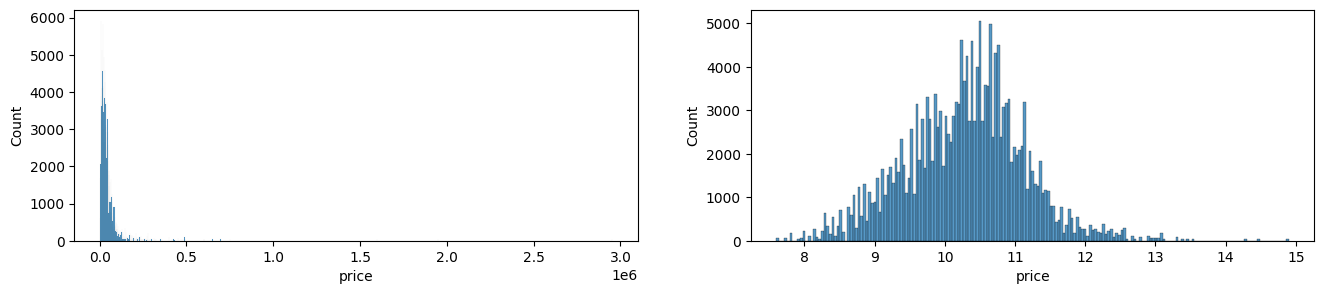

In [16]:
_, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_train[target], ax = axes[0])
sns.histplot(np.log(df_train[target]), ax = axes[1])
plt.show()

In [17]:
(df_train[target] > 250000).mean()

0.01071430465754006

- price에 지나치게 높은 값이 보입니다. 지표가 RMSE라 이상치에 민감합니다. 이를 어찌 할지 봐야 할 것 같습니다.

- Log 변환을 해보니 값이 좀더 고르게 됩니다. 하지만 지표가 RMSE라 Log 변환한 Target을 예측하는 게 도움이 되지 않을 가능성이 커보입니다.

In [18]:
df_train['price'].value_counts().sort_index(ascending = False).iloc[:20]

price
2954083    50
1950995    47
1599000    51
749950     48
695000     45
649999     34
599995     41
599000     36
491836     40
489995     40
489000     59
488880     44
479995     46
469900     57
449995     42
449991     30
429998     27
425000     43
417500     58
399950     61
Name: count, dtype: int64

In [19]:
df_train['price'].value_counts()

price
15000     1920
12000     1459
30000     1280
29000     1228
8500      1204
          ... 
239991      22
269991      22
259991      21
107998      20
45998       19
Name: count, Length: 1569, dtype: int64

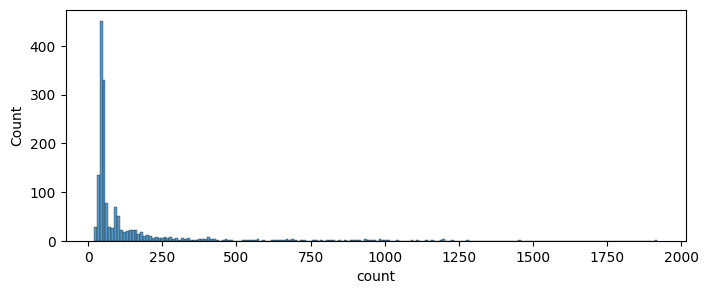

In [20]:
plt.figure(figsize = (8, 3))
sns.histplot(df_train['price'].value_counts())
plt.show()

동일한 가격이 반복적으로 나옵니다.

# Milage & Model Year

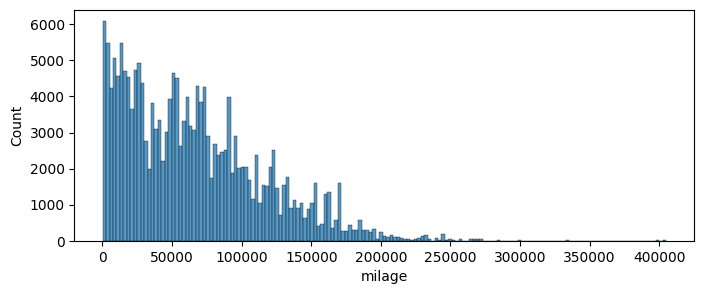

In [21]:
plt.figure(figsize = (8, 3))
sns.histplot(df_train, x = 'milage')
plt.show()

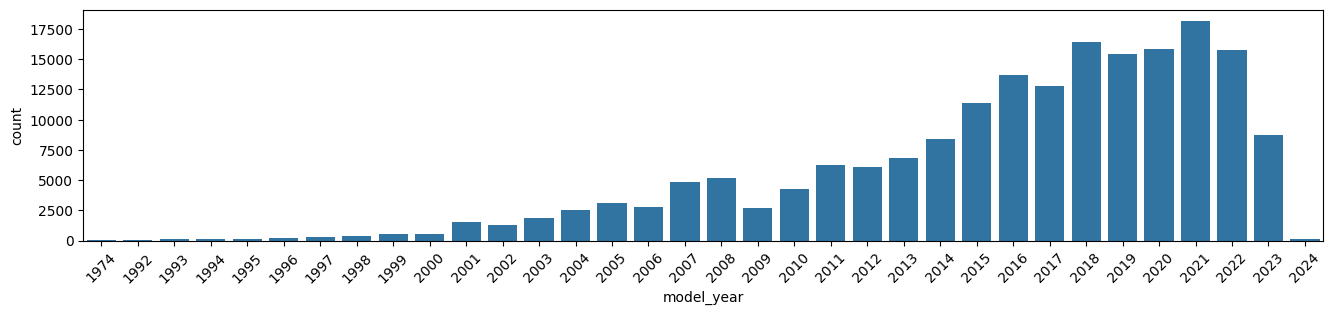

In [22]:
plt.figure(figsize = (16, 3))
sns.countplot(df_train, x = 'model_year')
plt.xticks(rotation = 45)
plt.show()

In [23]:
df_train.select_dtypes(exclude = 'category').corr()

,model_year,milage,price
model_year,1.000000,-0.669936,0.231795
milage,-0.669936,1.000000,-0.283067
price,0.231795,-0.283067,1.000000


## Relation with model_year

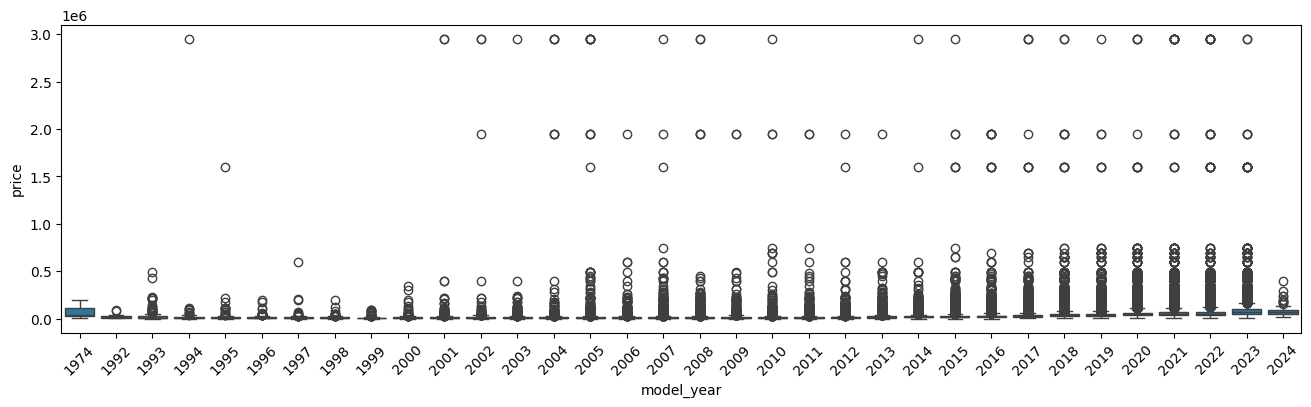

In [25]:
plt.figure(figsize = (16, 4))
sns.boxplot(df_train, x = 'model_year', y = target)
plt.xticks(rotation = 45)
plt.show()

- Outlier를 제외하고 출력을 해보겠습니다. Clipping을 통해 99분위수까지 값을 한정시켜놓겠습니다.

In [27]:
df_train = df_train.assign(
    price_c = lambda x: x[target].clip(0, x[target].quantile(0.99))
)

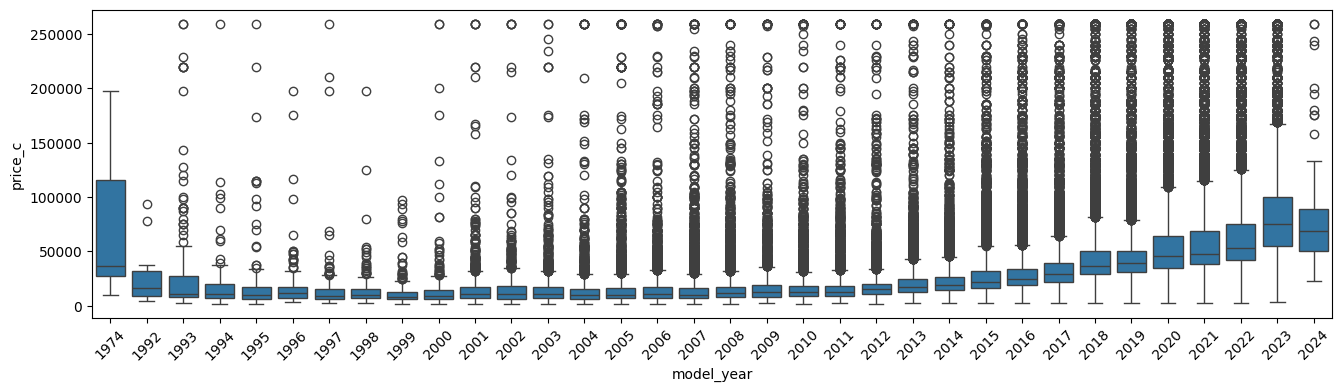

In [28]:
plt.figure(figsize = (16, 4))
sns.boxplot(df_train, x = 'model_year', y = 'price_c')
plt.xticks(rotation = 45)
plt.show()

- model_year가 1974는 다른 특징을 보이는데요...


In [29]:
(df_train['model_year'] == 1974).sum()

12

In [30]:
# 몇 건되지 않으니 살펴볼까요?
df_train.loc[df_train['model_year'] == 1974]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,price_c
id,,,,,,,,,,,,,
8173,Dodge,Challenger R/T Scat Pack,1974,49000,–,–,5-Speed M/T,Green,Gray,None reported,Yes,29900,29900
38565,Ford,Bronco,1974,38012,–,–,–,Thunder Gray,Dark Gray,None reported,Yes,84620,84620
47488,Ford,Bronco,1974,109762,Gasoline,–,–,Tempest,–,NaN,NaN,13046,13046
47837,Ford,Bronco XLT,1974,5856,–,–,6-Speed M/T,Black,Black,None reported,Yes,115000,115000
55169,Ford,Thunderbird Deluxe,1974,174678,Gasoline,280.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Beige,None reported,Yes,29998,29998
60702,Porsche,911 Carrera 4S,1974,102750,–,–,A/T,Gray,Gray,None reported,Yes,29000,29000
71389,Ford,Bronco XLT,1974,54323,–,–,4-Speed A/T,Blue,Beige,None reported,Yes,23500,23500
121193,Ford,Bronco,1974,7900,–,–,–,Gray,Gray,None reported,Yes,197499,197499
127656,Lincoln,Town Car Base,1974,152000,–,–,A/T,White,Beige,None reported,Yes,9999,9999


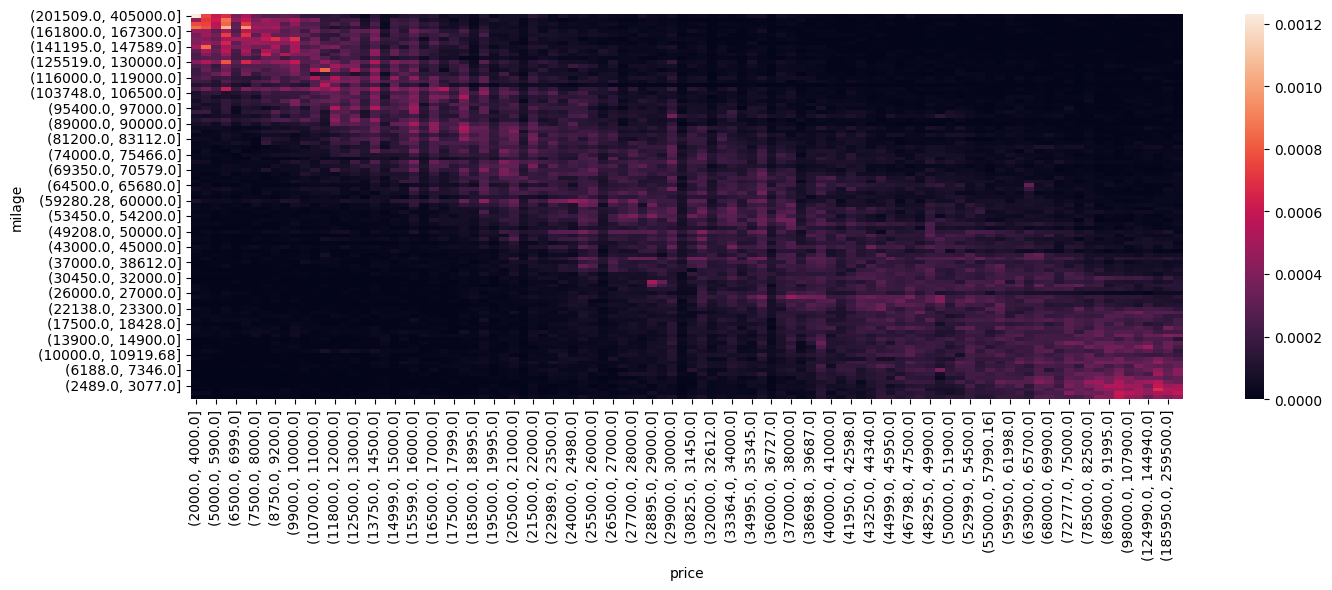

In [63]:
x = (df_train['milage'])
y = (df_train[target])
x_c = x.quantile(np.linspace(0, 1, 101)).round(3).drop_duplicates()
y_c = y.quantile(np.linspace(0, 1, 101)).round(3).drop_duplicates()
plt.figure(figsize=(16, 5))
sns.heatmap(
    pd.crosstab(
        index = pd.cut(x, x_c), columns = pd.cut(y, y_c), normalize = 'all'
    ).sort_index(ascending = False)
)
plt.show()

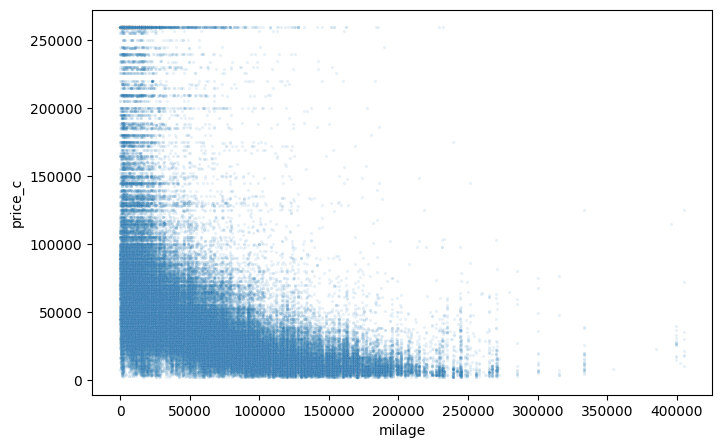

In [64]:
plt.figure(figsize = (8, 5))
sns.scatterplot(df_train, x = 'milage', y = 'price_c', alpha = 0.1, s = 5)
plt.show()

- milage와 price_c는 반비례 관계에 있습니다. 역수를 취해볼만 합니다.

In [257]:
df_train['milage_r'] = 1 / df_train['milage']

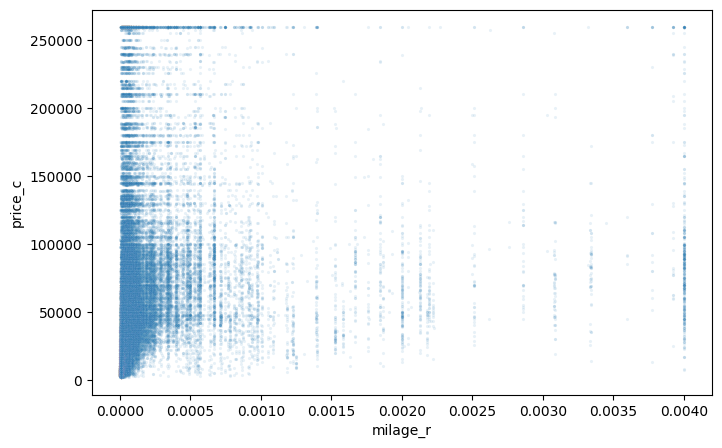

In [68]:
plt.figure(figsize = (8, 5))
sns.scatterplot(df_train.assign(milage_r = lambda x: x['milage_r'].clip(0, 0.004)), x = 'milage_r', y = 'price_c', alpha = 0.1, s = 5)
plt.show()

In [71]:
from scipy.stats import pearsonr
(
    pearsonr(df_train['milage_r'], df_train[target]),
    pearsonr(df_train['milage'], df_train[target])
)

(PearsonRResult(statistic=0.11604350623145308, pvalue=0.0),
 PearsonRResult(statistic=-0.28306749443632356, pvalue=0.0))

# brand

In [83]:
import warnings
warnings.simplefilter('ignore', category = FutureWarning)

In [85]:
df_train.groupby('brand')[target].agg(['mean', 'std', 'size']).sort_values('size', ascending = False)

,mean,std,size
brand,,,
Ford,40511.969508,76413.320245,23088
Mercedes-Benz,51244.399541,82931.938546,19172
BMW,43659.775487,57148.703421,17028
Chevrolet,41836.755127,71505.329531,16335
Audi,41004.856985,57831.867462,10887
Porsche,70899.947795,112993.037388,10612
Land,53204.880000,92001.935279,9525
Toyota,29147.812542,53561.945189,8850
Lexus,34801.090131,76900.316792,8643


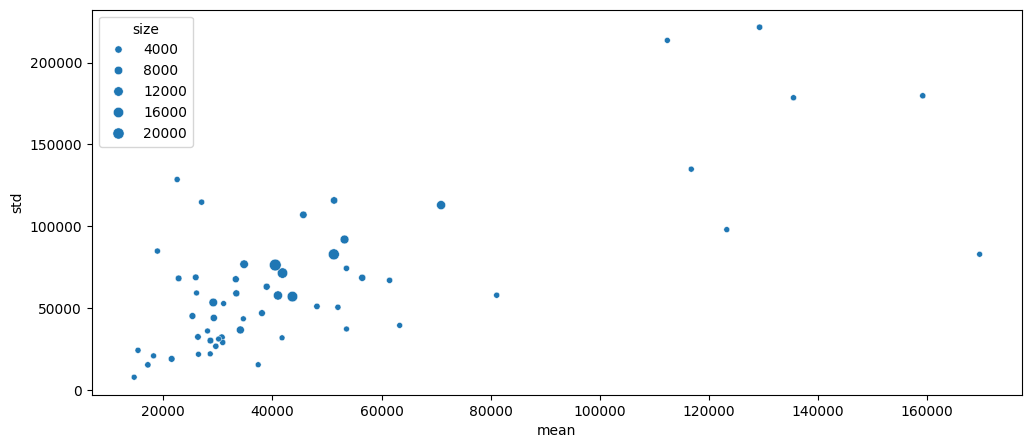

In [89]:
plt.figure(figsize = (12, 5))
df_train.groupby('brand')[target].agg(['mean', 'std', 'size']).pipe(
    lambda x: sns.scatterplot(x, x = 'mean', y = 'std', size = 'size')
)
plt.show()

## model

In [101]:
df_train['model'].value_counts()

model
F-150 XLT                        2945
M3 Base                          2229
Camaro 2SS                       1709
M4 Base                          1622
Mustang GT Premium               1526
                                 ... 
V60 T6 R-Design Platinum            2
X5 3.0i                             1
XLR Base                            1
Integra w/A-Spec Tech Package       1
X5 xDrive40e                        1
Name: count, Length: 1897, dtype: int64

In [102]:
dproc.combine_cat(df_train[['brand', 'model']]).value_counts().pipe(lambda x: x.loc[x > 0])

FordF-150 XLT                    2934
BMWM3 Base                       2195
ChevroletCamaro 2SS              1699
BMWM4 Base                       1608
FordMustang GT Premium           1515
                                 ... 
BMWILX 2.0L w/Premium Package       1
BMWA3 2.0T Premium                  1
TeslaMustang Mach-E Premium         1
DodgeMKZ Base                       1
KiaGenesis 3.8                      1
Name: count, Length: 3555, dtype: int64

- brand는 model의 종속관계 일 텐데, 따르지 않은 케이스들이 있어 보입니다. 이러한 노이즈가 예측에 미치는 영향을 살펴봐야 겠습니다.

In [104]:
df_train['model'].value_counts().iloc[-20:]

model
X5 eDrive xDrive40e              3
Ascent Limited 7-Passenger       3
370Z NISMO                       3
Stinger GT                       3
Insight EX                       3
740e xDrive iPerformance         3
XC60 3.2                         3
500e Battery Electric            3
X3 xDrive35i                     2
IONIQ Plug-In Hybrid SEL         2
XLR V                            2
X5 3.0si                         2
ForTwo Pure                      2
X5 xDrive 35i Sport Activity     2
Forte LX                         2
V60 T6 R-Design Platinum         2
X5 3.0i                          1
XLR Base                         1
Integra w/A-Spec Tech Package    1
X5 xDrive40e                     1
Name: count, dtype: int64

- 파편화 되어 있습니다. 파편화의 영향도를 볼필요가 있습니다.

In [120]:
df_train.groupby('model', observed = True)[target].agg(
    ['mean', 'std', 'size']
).query('size >= 1000').sort_values('size', ascending = False)

,mean,std,size
model,,,
F-150 XLT,42709.795925,62917.231519,2945
M3 Base,38032.437865,58882.401392,2229
Camaro 2SS,35962.599766,30270.240199,1709
M4 Base,58951.160296,78934.909967,1622
Mustang GT Premium,33148.771298,30567.576722,1526
F-150 Lariat,40947.711348,29580.268537,1410
E-Class E 350 4MATIC,24167.272660,31506.738538,1357
1500 Laramie,65848.744596,162633.000525,1249
911 Carrera S,83683.102543,109444.202623,1219


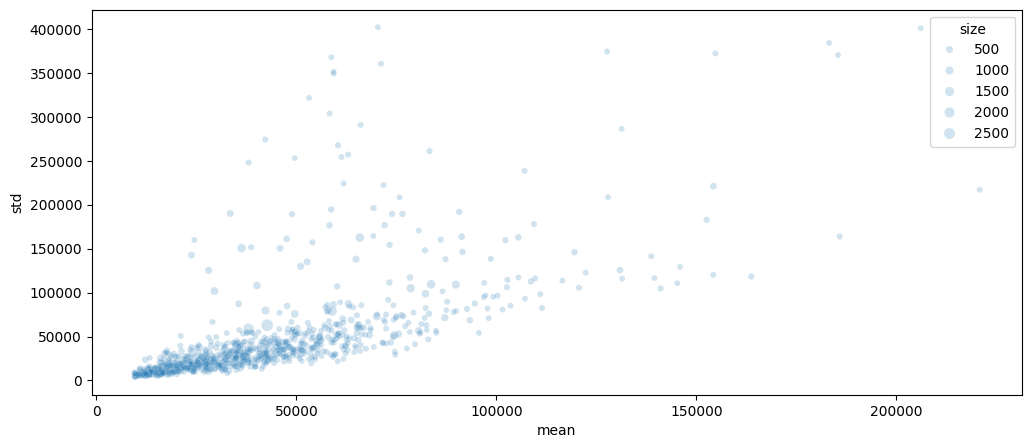

In [123]:
plt.figure(figsize = (12, 5))
df_train.groupby('model', observed = True)[target].agg(
    ['mean', 'std', 'size']
).query('size >= 50').pipe(
    lambda x: sns.scatterplot(x, x = 'mean', y = 'std', size = 'size', alpha = 0.2)
)
plt.show()

## fuel_type

In [105]:
df_train['fuel_type'].value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [258]:
df_train.loc[df_train['fuel_type'].isna(), target].agg(['mean', 'std', 'size'])

mean    60822.612040
std     67237.070325
size     5083.000000
Name: price, dtype: float64

In [115]:
from scipy.stats import mannwhitneyu
mannwhitneyu(
    *df_train.loc[df_train['fuel_type'].isin(['–', 'not supported'])].groupby('fuel_type', observed = True)[target].agg(list)
)

MannwhitneyuResult(statistic=6414.5, pvalue=0.5280832141725111)

- –와 not supported에 따른 target에 대한 차이가 없다고 할 수 있는데요. 정리에 따른 효과가있을 지 보겠습니다.

In [124]:
df_train.groupby('fuel_type')[target].agg(['mean', 'std', 'size']).sort_values('size', ascending = False)

,mean,std,size
fuel_type,,,
Gasoline,43360.013782,79805.746347,165940
Hybrid,55473.451698,57999.203856,6832
E85 Flex Fuel,26729.755457,54669.855994,5406
Diesel,48769.587358,93900.220809,3955
–,36414.285531,128210.312158,781
Plug-In Hybrid,44150.967370,29218.461832,521
not supported,20692.733333,17726.392428,15


– 는 분산이 큽니다.

## engine

In [129]:
df_train['engine'].value_counts()

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel           3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel           2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel           2841
2.0L I4 16V GDI DOHC Turbo                             2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          2451
                                                       ... 
70.0HP 1.0L 3 Cylinder Engine Gasoline Fuel               1
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid        1
111.0HP Electric Motor Electric Fuel System               1
443.0HP 4.4L 8 Cylinder Engine Gasoline Fuel              1
313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas       1
Name: count, Length: 1117, dtype: int64

In [131]:
df_train['model'].value_counts()

model
F-150 XLT                        2945
M3 Base                          2229
Camaro 2SS                       1709
M4 Base                          1622
Mustang GT Premium               1526
                                 ... 
V60 T6 R-Design Platinum            2
X5 3.0i                             1
XLR Base                            1
Integra w/A-Spec Tech Package       1
X5 xDrive40e                        1
Name: count, Length: 1897, dtype: int64

In [130]:
dproc.combine_cat(df_train[['model', 'engine']]).value_counts().pipe(lambda x: x.loc[x > 0])

M4 Base425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel           1529
Camaro 2SS455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel                 1297
Corvette Stingray w/2LT490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel     997
1500 Laramie5.7L V8 16V MPFI OHV                                        975
GX 460 Base301.0HP 4.6L 8 Cylinder Engine Gasoline Fuel                 973
                                                                       ... 
720S Performance611.0HP 3.9L 8 Cylinder Engine Gasoline Fuel              1
Edge Sport250.0HP 2.7L V6 Cylinder Engine Gasoline Fuel                   1
Genesis Coupe 2.0T252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel            1
Crossfire Limited300.0HP 4.3L 8 Cylinder Engine Gasoline Fuel             1
A7 Premium2.0L I4 16V GDI DOHC Turbo Hybrid                               1
Name: count, Length: 18797, dtype: int64

- model에 따라서 engine이 고정되어 있지는 않습니다.
- 4개의 항목이 결합되어 있습니다. HP, displacement, Cyline num, fuel_type 으로 되어 있습니다.

In [132]:
df_train['engine_str'] = df_train['engine'].astype('str')

In [221]:
fuel_pat = "(?P<fuel_type_engine>Gasoline Fuel|Flex Fuel Capability|Diesel Fuel|Gasoline\\/Mild Electric Hybrid|Gas\\/Electric Hybrid|Plug-In Electric\\/Gas|Electric Fuel System|[0-9]+V .*|DOHC Turbo|Turbo)"
df_engine_attr = pd.concat([
    df_train['engine_str'].str.extract("(?P<HP>[0-9.]+)HP ").astype('float16'), 
    df_train['engine_str'].str.extract("(?P<displacement>[0-9.]+)L|Liter").astype('float16'), 
    df_train['engine_str'].str.extract("(?P<engine_type>[^ ]+ Cylinder Engine|Electric Motor| [VI][0-9]+ )"),
    df_train['engine_str'].str.extract(fuel_pat)
], axis=1)
df_engine_attr

,HP,displacement,engine_type,fuel_type_engine
id,,,,
0,172.0,1.599609,4 Cylinder Engine,Gasoline Fuel
1,252.0,3.900391,8 Cylinder Engine,Gasoline Fuel
2,320.0,5.300781,8 Cylinder Engine,Flex Fuel Capability
3,420.0,5.000000,8 Cylinder Engine,Gasoline Fuel
4,208.0,2.000000,4 Cylinder Engine,Gasoline Fuel
...,...,...,...,...
188528,420.0,6.199219,8 Cylinder Engine,Gasoline Fuel
188529,385.0,3.000000,V6,Gasoline Fuel
188530,469.0,4.000000,8 Cylinder Engine,Gasoline Fuel


In [222]:
df_engine_attr.isna().sum().rename('na_cnt').to_frame().T

,HP,displacement,engine_type,fuel_type_engine
na_cnt,33259,14214,10470,6422


In [223]:
df_engine_attr.apply(lambda x: x.nunique()).rename('n_unique').to_frame().T

,HP,displacement,engine_type,fuel_type_engine
n_unique,348,61,15,64


In [228]:
df_engine_attr['fuel_type_engine'].value_counts()

fuel_type_engine
Gasoline Fuel                    136161
Flex Fuel Capability               5168
Electric Fuel System               4949
Diesel Fuel                        3691
Gasoline/Mild Electric Hybrid      3573
                                  ...  
32V MPFI DOHC Supercharged            9
12V MPFI DOHC Turbo                   8
16V GDI DOHC Flexible Fuel            8
18V MPFI SOHC                         8
12V MPFI OHV                          2
Name: count, Length: 64, dtype: int64

In [229]:
df_train = df_train.join(df_engine_attr)

In [231]:
df_train.loc[df_train['HP'].notna()].pipe(
    lambda x: pearsonr(x[target], x['HP'])
)

PearsonRResult(statistic=0.2761348603535596, pvalue=0.0)

In [232]:
df_train.loc[df_train['displacement'].notna()].pipe(
    lambda x: pearsonr(x[target], x['displacement'])
)

PearsonRResult(statistic=0.0969642278366583, pvalue=0.0)

In [234]:
df_train.groupby('engine_type')[target].agg(['mean', 'std', 'size'])

,mean,std,size
engine_type,,,
I3,38929.636719,22667.505607,256
I4,41699.967872,78483.810821,5945
I6,84333.596215,112579.607174,317
V10,157057.686375,165473.083562,389
V12,173761.592593,202162.274344,405
V6,35437.337515,60242.056491,57547
V8,88066.139387,154318.845273,6916
10 Cylinder Engine,61702.604585,130693.677883,698
12 Cylinder Engine,101815.500000,213825.675168,1266


## transmission

In [237]:
df_train['transmission'].value_counts()

transmission
A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      2325
CVT Transmission           

- 동일해 보이는 범주이지만 스펠링의 차이에 의해 다르게 분류가 되는 듯해 보입니다. 이런 변수를 정리해야하는 지 살펴볼 필요가 있습니다.

In [238]:
df_train.groupby('transmission')[target].agg(['mean', 'std', 'size'])

,mean,std,size
transmission,,,
A/T,31711.979140,54662.119814,49904
Transmission w/Dual Shift Mode,50201.815580,82731.475612,19255
7-Speed A/T,47123.507371,71966.947586,11124
8-Speed A/T,56442.748656,76368.801712,20645
10-Speed Automatic,63990.058786,150482.335890,3164
1-Speed A/T,57869.525415,45780.340817,1869
6-Speed A/T,25864.659998,44025.724145,18044
10-Speed A/T,58806.705992,53280.659123,8044
9-Speed A/T,58859.512675,69040.944607,3866


## ext_col

In [241]:
df_train['ext_col'].value_counts().iloc[:30]

ext_col
Black                                 48658
White                                 43815
Gray                                  25293
Silver                                16995
Blue                                  14555
Red                                    9901
Green                                  2698
Gold                                   1668
Brown                                  1162
Orange                                 1139
Beige                                  1087
Yellow                                  978
Bright White Clearcoat                  755
Diamond Black                           711
Agate Black Metallic                    639
Summit White                            514
Silver Ice Metallic                     456
Mythos Black Metallic                   417
Midnight Black Metallic                 379
–                                       366
Granite Crystal Clearcoat Metallic      365
Purple                                  354
Santorini Black Metallic

In [244]:
df_train.groupby('ext_col')[target].agg(['mean', 'std', 'size']).sort_values('size', ascending = False).iloc[:30]

,mean,std,size
ext_col,,,
Black,42417.511447,74842.550002,48658
White,40803.542622,71438.903786,43815
Gray,47908.967106,71111.638221,25293
Silver,31878.405296,66972.852084,16995
Blue,40658.658811,67209.124007,14555
Red,39977.708413,83624.851523,9901
Green,53064.767976,111188.112557,2698
Gold,23090.873501,104797.226577,1668
Brown,33947.655766,48012.352386,1162


## int_col

In [246]:
df_train.groupby('ext_col')[target].agg(['mean', 'std', 'size']).sort_values('size', ascending = False).iloc[:30]

,mean,std,size
ext_col,,,
Black,42417.511447,74842.550002,48658
White,40803.542622,71438.903786,43815
Gray,47908.967106,71111.638221,25293
Silver,31878.405296,66972.852084,16995
Blue,40658.658811,67209.124007,14555
Red,39977.708413,83624.851523,9901
Green,53064.767976,111188.112557,2698
Gold,23090.873501,104797.226577,1668
Brown,33947.655766,48012.352386,1162


- – 가 있는 범주들은 분산도 높고 가격도 높아 보입니다. – 의 개수를 카운팅 해보는 게 좋을 듯합니다.

## accident

In [248]:
df_train['accident'].value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

In [250]:
df_train.groupby('accident')[target].agg(['mean', 'std', 'size'])

,mean,std,size
accident,,,
None reported,49024.804144,84593.013790,144514
At least 1 accident or damage reported,25334.071475,47378.623057,41567


In [259]:
df_train.loc[df_train['accident'].isna(), target].agg(['mean', 'std', 'size'])

mean     54902.988989
std     101802.822367
size      2452.000000
Name: price, dtype: float64

- accident의 가격에 대한 영향은 커보입니다.

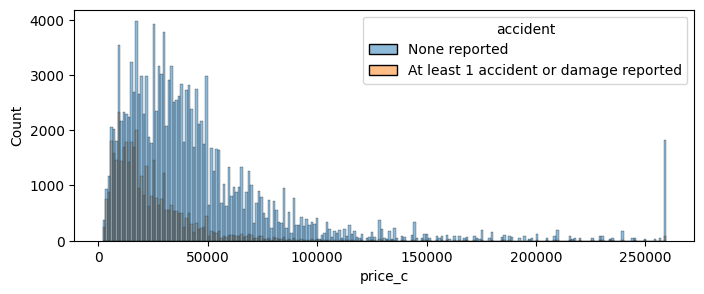

In [274]:
plt.figure(figsize = (8, 3))
sns.histplot(df_train, x = 'price_c' ,hue = 'accident')
plt.show()

##  clean_title

In [255]:
df_train['clean_title'] = df_train['clean_title'].astype('str').fillna('no').astype('category')

In [256]:
df_train.groupby('clean_title')[target].agg(['mean', 'std', 'size'])

,mean,std,size
clean_title,,,
Yes,41354.406704,76421.863672,167114
nan,63567.566273,93164.463662,21419


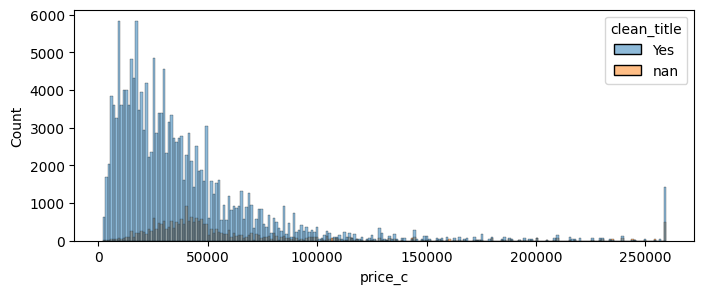

In [272]:
plt.figure(figsize = (8, 3))
sns.histplot(df_train, x = 'price_c' ,hue = 'clean_title')
plt.show()

- 역시 영향력이 꽤 있습니다.

In [262]:
(df_train.select_dtypes('category') == '–').sum()

brand              0
model              0
fuel_type        781
engine           925
transmission      87
ext_col          366
int_col         4527
accident           0
clean_title        0
dtype: int64

In [269]:
df_train.groupby(
    (df_train[['fuel_type', 'engine', 'transmission', 'ext_col', 'int_col']] == '–').sum(axis = 1)
)[target].agg(['mean', 'std', 'size'])

,mean,std,size
0,43748.445491,78096.341762,182886
1,46250.037093,87614.140063,4664
2,53362.880388,133110.603253,928
3,111757.500000,246756.786801,54
4,209991.000000,NaN,1
